In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem


from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.8766646.datarmor0/parcels-502090/libparcels_random_0812b52c-3538-4e11-a60f-70296f24ca61.so


In [43]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=4, cores=4) #processes=7, cores=7
w = cluster.scale(jobs=5
                 )
#
client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://10.148.0.71:42750 Dashboard: http://10.148.0.71:8787/status,Cluster Workers: 35 Cores: 35 Memory: 558.95 GiB


In [4]:
# Load Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'
p = pa.parcels_output(root_dir+run_name, parquets=['time'])
df = p['time']

In [130]:
df

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
npartitions=378,,,,,,,,,
,int32,float64,float64,float64,float32,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


In [131]:
lonmin,lonmax = -180,180
latmin,latmax = -60,60

In [132]:
binsize = 2.
lon_bins,lat_bins = np.arange(lonmin,lonmax,binsize),np.arange(latmin,latmax,binsize)
x_idx,y_idx = pd.IntervalIndex.from_breaks(lon_bins),pd.IntervalIndex.from_breaks(lat_bins)
df['lon_cut'] = df['lon'].map_partitions(pd.cut, bins=lon_bins)
df['lat_cut'] = df['lat'].map_partitions(pd.cut, bins=lat_bins)

In [133]:
num_id = df.groupby(['lon_cut','lat_cut']).count().persist()

In [134]:
num_id = num_id.iloc[:,:2].compute()

In [135]:
num = num_id.reset_index()

In [136]:
num['lon_bins'] = num.lon_cut.apply(lambda x : x.mid)
num['lat_bins'] = num.lat_cut.apply(lambda x : x.mid)

<AxesSubplot:xlabel='lon_bins', ylabel='lat_bins'>

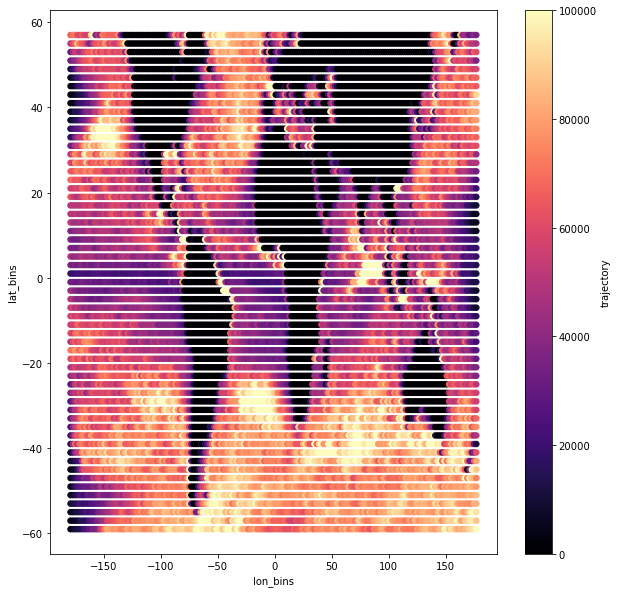

In [128]:
fig,ax = plt.subplots(figsize=(10,10))
num.plot.scatter(x='lon_bins',y='lat_bins',c='trajectory',s=30,cmap='magma',ax=ax,vmax=100000)

(0.0, 120.0)

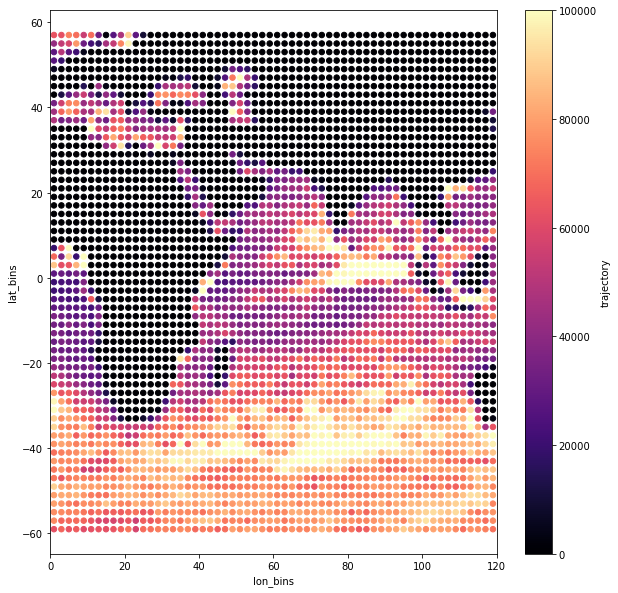

In [138]:
fig,ax = plt.subplots(figsize=(10,10))
num.plot.scatter(x='lon_bins',y='lat_bins',c='trajectory',s=30,cmap='magma',ax=ax,vmax=100000)
plt.xlim(0,120)

In [44]:
# Load Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'

#run_name_old = 'global_extra_T365j_dt1j_dij50'
parcels_index = ['autocov_demodulation_vr_vr','autocov_demodulation_vr_vi'] #,'autocov_demodulation_ri'
name = ['rr','ri']
df = {}
for i,parcels_id in enumerate(parcels_index):
# choose to select time indexed data for now
    p = pa.parcels_output(root_dir+run_name, parquets=[parcels_id])
#    name = parcels_id[-2:]
    df[name[i]] = p[parcels_id]
df['rr'].head()

,trajectory,time,lon,lat,id,0.0,0.041666666666666664,0.08333333333333333,0.125,0.16666666666666666,...,39.625,39.666666666666664,39.70833333333333,39.75,39.791666666666664,39.83333333333333,39.875,39.916666666666664,39.95833333333333,40.0
0,2000210,40,-30.212397,-67.085316,2000210.0,0.000053,0.000053,0.000053,0.000053,0.000052,...,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000015,-0.000016,-0.000016
1,2000210,80,-32.601339,-66.594248,2000210.0,0.000135,0.000135,0.000135,0.000135,0.000134,...,-0.000053,-0.000053,-0.000053,-0.000053,-0.000053,-0.000053,-0.000053,-0.000053,-0.000053,-0.000053
2,2000210,120,-34.386644,-65.928701,2000210.0,0.000064,0.000064,0.000064,0.000064,0.000064,...,-0.000023,-0.000024,-0.000025,-0.000025,-0.000026,-0.000027,-0.000028,-0.000029,-0.000029,-0.000030
3,2000210,160,-35.887227,-65.091353,2000210.0,0.000031,0.000031,0.000031,0.000031,0.000031,...,-0.000024,-0.000024,-0.000024,-0.000025,-0.000025,-0.000025,-0.000025,-0.000026,-0.000026,-0.000026
4,2000210,200,-35.326183,-64.367650,2000210.0,0.000041,0.000041,0.000041,0.000040,0.000040,...,-0.000006,-0.000006,-0.000007,-0.000007,-0.000007,-0.000007,-0.000007,-0.000008,-0.000008,-0.000008


In [45]:
# add bathymetry to dataframe
def interp_bathy(df):
    bathy = ut.load_bathy(15)
    ds = df[['lon','lat']].to_xarray()
    ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
    df_interpolated = ds_interpolated.to_dataframe()[bathy.name]
    return df.assign(**{bathy.name: df_interpolated})

for k in df.keys():
    df[k]= df[k].map_partitions(interp_bathy)

In [46]:
for k in df.keys():
    df[k] = df[k].where(df[k].h>500).persist()

In [47]:
lonmin,lonmax = np.around(df['rr'].lon.min().compute()),np.around(df['rr'].lon.max().compute())
latmin,latmax = np.around(df['rr'].lat.min().compute()),np.around(df['rr'].lat.max().compute())

In [48]:
binsize = 1
def binning(_df,binsize):
    lon_bins,lat_bins = np.arange(lonmin,lonmax,binsize),np.arange(latmin,latmax,binsize)
    x_idx,y_idx = pd.IntervalIndex.from_breaks(lon_bins),pd.IntervalIndex.from_breaks(lat_bins)
    _df['lon_cut'] = _df['lon'].map_partitions(pd.cut, bins=lon_bins)
    _df['lat_cut'] = _df['lat'].map_partitions(pd.cut, bins=lat_bins)
    _df = _df.drop(columns=['id','time','lon','lat','trajectory' ,'h']) # ,'h'
    _df = _df.rename(columns={c:float(c) for c in _df.columns[:-2]})
    return _df
for k in df.keys():
    df[k] = binning(df[k],binsize).persist()

In [49]:
from dask.distributed import wait
df_mean = {}
for k in df.keys():
    df_mean[k] = df[k].groupby(['lon_cut','lat_cut']).mean().persist()#apply(lambda x: x.mean(skipna=False)).persist()
    df_mean[k] = df_mean[k].reset_index()
df_mean['count'] = df[k].groupby(['lon_cut','lat_cut']).count().persist()

In [50]:
_count = df_mean['count'].reset_index()#.to_dask_array().compute()

In [51]:
_count['lon_bins'] = _count.lon_cut.apply(lambda x :x.mid)
_count['lat_bins'] = _count.lat_cut.apply(lambda x :x.mid)
_count = _count.drop(columns=['lon_cut','lat_cut']).persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3522: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('lon_cut', 'category'))

  warnings.warn(meta_warning(meta))
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3522: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func

In [52]:
_count = _count.to_dask_array().compute()

In [83]:
_count[:,-2]

array([-179.5, -179.5, -179.5, ...,  178.5,  178.5,  178.5])

In [53]:
df_melted = {}
#k = 'rr'
for k in ['rr','ri']:
    df_melted[k] = dd.melt(df_mean[k],id_vars=['lon_cut','lat_cut'],var_name='lags').persist()
    df_melted[k]['lon_bins'] = df_melted[k].lon_cut.apply(lambda x :x.mid)
    df_melted[k]['lat_bins'] = df_melted[k].lat_cut.apply(lambda x :x.mid)
    df_melted[k] = df_melted[k].drop(columns=['lon_cut','lat_cut']).persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3522: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('lon_cut', 'category'))

  warnings.warn(meta_warning(meta))
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3522: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func

In [54]:
ds = {}
ds['rr'] = df_melted['rr'].rename(columns={'value': 'rr'}).to_dask_array()
ds['rr'] = ds['rr'].compute()
ds['rr']

array([[0.0, 0.00037333651693204767, -179.5, -77.5],
       [0.0, 0.0003436007492643982, -179.5, -76.5],
       [0.0, 0.00037036477879136303, -179.5, -75.5],
       ...,
       [40.0, nan, 178.5, 68.5],
       [40.0, nan, 178.5, 69.5],
       [40.0, nan, 178.5, 70.5]], dtype=object)

In [55]:
ds['ri'] = df_melted['ri'].rename(columns={'value': 'ri'}).to_dask_array()
ds['ri'] = ds['ri'].compute()
ds['ri']

array([[0.0, -7.54250639366722e-07, -179.5, -77.5],
       [0.0, 5.321153648075876e-05, -179.5, -76.5],
       [0.0, -4.905352623751675e-05, -179.5, -75.5],
       ...,
       [40.0, nan, 178.5, 68.5],
       [40.0, nan, 178.5, 69.5],
       [40.0, nan, 178.5, 70.5]], dtype=object)

In [56]:
ds_out = {}
ds_out['rr'] = xr.Dataset({'rr':(["index"], ds['rr'][:,1])},coords={'lags':(["index"],ds['rr'][:,0]),'lon_bins':(["index"],ds['rr'][:,2]),'lat_bins':(["index"],ds['rr'][:,3])}
                   ).set_index(index = ['lat_bins','lon_bins','lags']).unstack()
ds_out['ri'] = xr.Dataset({'ri':(["index"], ds['ri'][:,1])},coords={'lags':(["index"],ds['ri'][:,0]),'lon_bins':(["index"],ds['ri'][:,2]),'lat_bins':(["index"],ds['ri'][:,3])}
                   ).set_index(index = ['lat_bins','lon_bins','lags']).unstack()

In [46]:
ds_out

{'rr': <xarray.Dataset>
 Dimensions:   (lags: 961, lat_bins: 74, lon_bins: 179)
 Coordinates:
   * lat_bins  (lat_bins) float64 -77.0 -75.0 -73.0 -71.0 ... 63.0 65.0 67.0 69.0
   * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
   * lags      (lags) float64 0.0 0.04167 0.08333 0.125 ... 39.92 39.96 40.0
 Data variables:
     rr        (lat_bins, lon_bins, lags) object 0.0007699 0.0007697 ... nan nan,
 'ri': <xarray.Dataset>
 Dimensions:   (lags: 961, lat_bins: 74, lon_bins: 179)
 Coordinates:
   * lat_bins  (lat_bins) float64 -77.0 -75.0 -73.0 -71.0 ... 63.0 65.0 67.0 69.0
   * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
   * lags      (lags) float64 0.0 0.04167 0.08333 0.125 ... 39.92 39.96 40.0
 Data variables:
     ri        (lat_bins, lon_bins, lags) object 0.0003208 0.0003271 ... nan nan}

In [57]:
ds_out['count'] = xr.Dataset({'count':(["index"], _count[:,0])},coords={'lon_bins':(["index"],_count[:,-2]),
                                                                    'lat_bins':(["index"],_count[:,-1])}
                        ).set_index(index = ['lat_bins','lon_bins']).unstack()

In [58]:
for k in ds_out.keys():
    ds_out[k] = ds_out[k].astype(np.float64)

In [59]:
_ds = xr.merge([ds_out[k] for k in ds_out.keys()])

In [60]:
_ds

<xarray.Dataset>
Dimensions:   (lags: 961, lat_bins: 149, lon_bins: 359)
Coordinates:
  * lat_bins  (lat_bins) float64 -77.5 -76.5 -75.5 -74.5 ... 67.5 68.5 69.5 70.5
  * lon_bins  (lon_bins) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
  * lags      (lags) float64 0.0 0.04167 0.08333 0.125 ... 39.92 39.96 40.0
Data variables:
    rr        (lat_bins, lon_bins, lags) float64 0.0003733 0.0003735 ... nan nan
    ri        (lat_bins, lon_bins, lags) float64 -7.543e-07 1.498e-06 ... nan
    count     (lat_bins, lon_bins) float64 8.0 19.0 18.0 33.0 ... 0.0 0.0 0.0

(-180.0, 180.0)

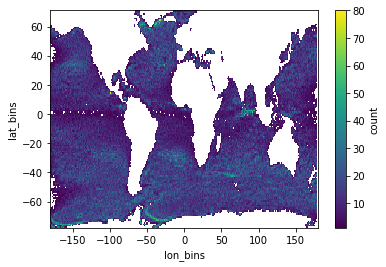

In [61]:
_ds['count'].where(_ds['count']>0).plot(y='lat_bins')
plt.xlim(-180,180)

Text(0.5, 1.0, '')

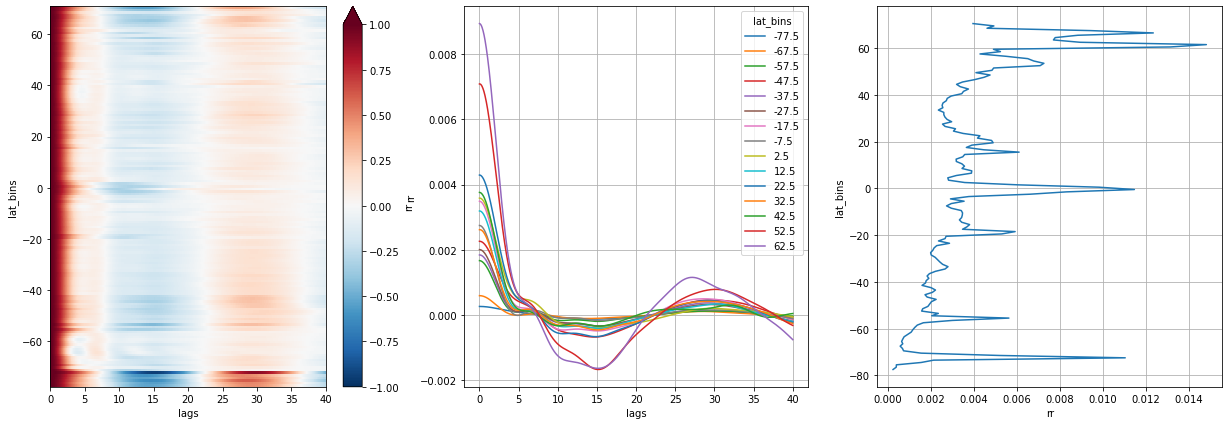

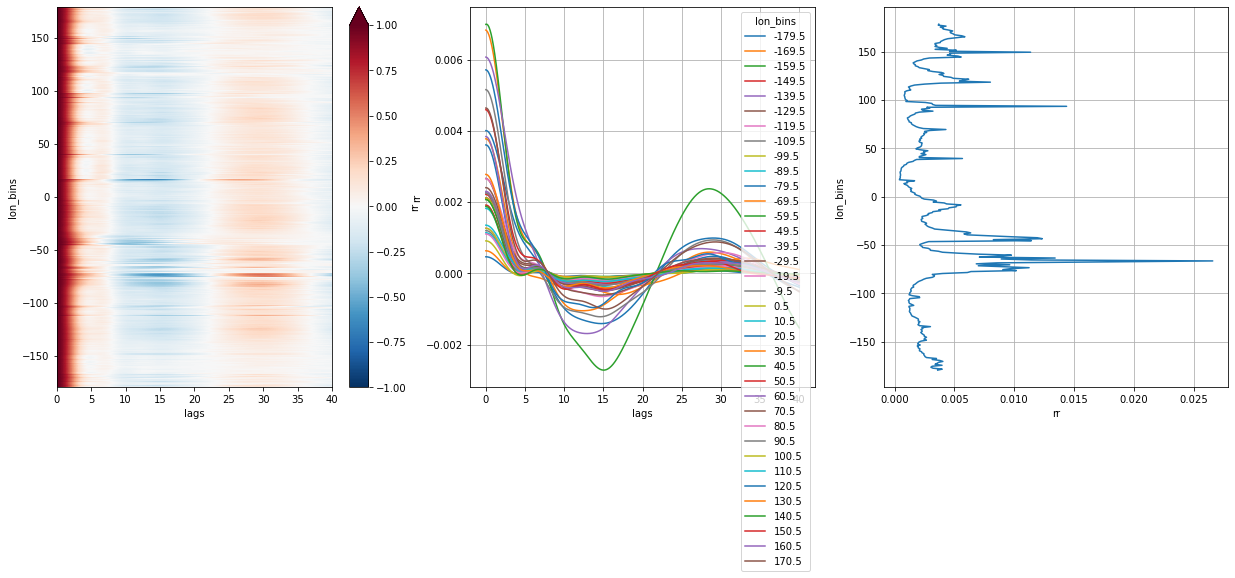

In [62]:
fig,ax = plt.subplots(1,3,figsize=(21,7))
(_ds.rr.mean('lon_bins')/_ds.rr.mean('lon_bins').isel(lags=0)).plot(ax=ax[0],vmax=1)
(_ds.rr.mean('lon_bins').isel(lat_bins=slice(0,None,10))).plot(ax=ax[1],hue='lat_bins')
ax[1].grid();
_ds.rr.mean('lon_bins').isel(lags=0).plot(ax=ax[2],y='lat_bins');ax[2].grid();
ax[2].set_title('')
fig,ax = plt.subplots(1,3,figsize=(21,7))
(_ds.rr.mean('lat_bins')/_ds.rr.mean('lat_bins').isel(lags=0)).plot(ax=ax[0],vmax=1)
(_ds.rr.mean('lat_bins').isel(lon_bins=slice(0,None,10))).plot(ax=ax[1],hue='lon_bins')
ax[1].grid();
_ds.rr.mean('lat_bins').isel(lags=0).plot(ax=ax[2],y='lon_bins');ax[2].grid();
ax[2].set_title('')

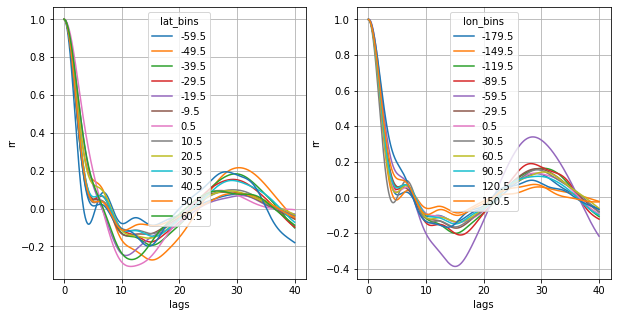

In [63]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
(_ds.rr.mean('lon_bins')/_ds.rr.mean('lon_bins').isel(lags=0)).sel(lat_bins=slice(-60,70,10)).plot(hue='lat_bins',ax=axs[0])
(_ds.rr.mean('lat_bins')/_ds.rr.mean('lat_bins').isel(lags=0)).sel(lon_bins=slice(-180,180,30)).plot(hue='lon_bins',ax=axs[1])
for ax in axs:
    ax.grid()

Text(0.5, 1.0, '')

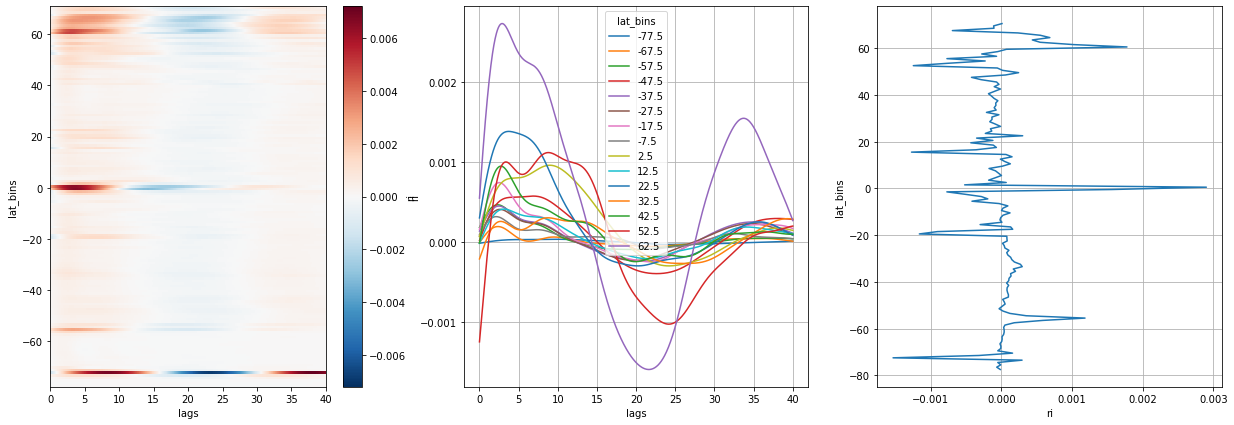

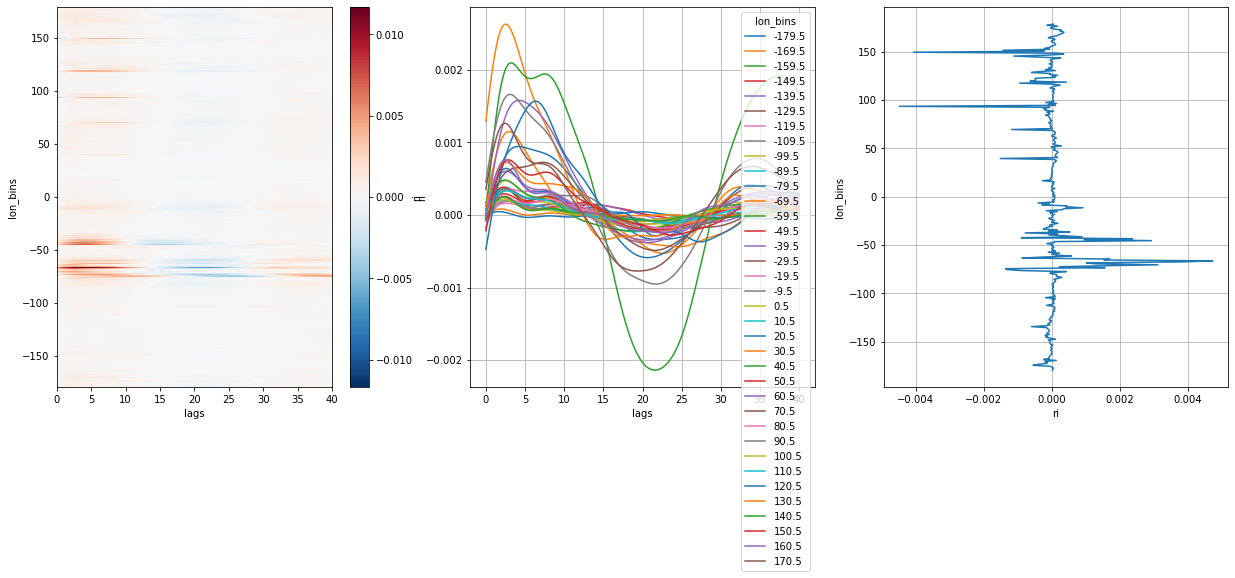

In [64]:
fig,ax = plt.subplots(1,3,figsize=(21,7))
(_ds.ri.mean('lon_bins')).plot(ax=ax[0])
(_ds.ri.mean('lon_bins').isel(lat_bins=slice(0,None,10))).plot(ax=ax[1],hue='lat_bins')
ax[1].grid();
_ds.ri.mean('lon_bins').isel(lags=0).plot(ax=ax[2],y='lat_bins');ax[2].grid();
ax[2].set_title('')
fig,ax = plt.subplots(1,3,figsize=(21,7))
(_ds.ri.mean('lat_bins')).plot(ax=ax[0])
(_ds.ri.mean('lat_bins').isel(lon_bins=slice(0,None,10))).plot(ax=ax[1],hue='lon_bins')
ax[1].grid();
_ds.ri.mean('lat_bins').isel(lags=0).plot(ax=ax[2],y='lon_bins');ax[2].grid();
ax[2].set_title('')

(-180.0, 180.0)

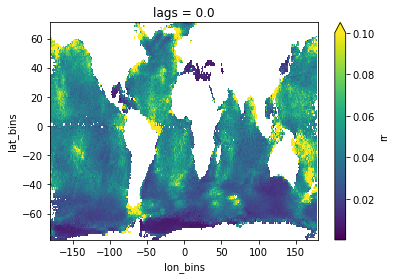

In [65]:
# square root of the autocovariance at lag 0 (~$\widetilde{V})
np.sqrt(_ds.rr.isel(lags=0)).plot(y='lat_bins',vmax=1e-1)
plt.xlim(-180,180)

In [66]:
_ds.attrs.update({'binsize':binsize})
_ds

<xarray.Dataset>
Dimensions:   (lags: 961, lat_bins: 149, lon_bins: 359)
Coordinates:
  * lat_bins  (lat_bins) float64 -77.5 -76.5 -75.5 -74.5 ... 67.5 68.5 69.5 70.5
  * lon_bins  (lon_bins) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
  * lags      (lags) float64 0.0 0.04167 0.08333 0.125 ... 39.92 39.96 40.0
Data variables:
    rr        (lat_bins, lon_bins, lags) float64 0.0003733 0.0003735 ... nan nan
    ri        (lat_bins, lon_bins, lags) float64 -7.543e-07 1.498e-06 ... nan
    count     (lat_bins, lon_bins) float64 8.0 19.0 18.0 33.0 ... 0.0 0.0 0.0
Attributes:
    binsize:  1

In [67]:
_ = _ds.to_netcdf(path='/home1/datawork/zcaspar/mit4320/binned_Lcov_vv_dl1.nc')

In [68]:
#client.restart()
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
